In [1]:
import sys, os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from skimage import data, color, morphology
from skimage import io
from skimage.color import rgb2hed
from matplotlib.colors import LinearSegmentedColormap
from pathlib import Path
from natsort import natsorted
import numpy as np
import pandas as pd
from skimage.color import rgb2gray
from scipy import stats
from datetime import datetime
def rgb_red2gray(rgb):
    return np.dot(rgb[...,:3], [1, 0, 0])

## IncuCyte TMRE assay
This program will take background subtracted TIFF files from IncuCyte fluorescence microscope and assign TMRE fluorescence, filter for outlier pixels and subtract background. TMRE intensity is controlled by the mitochondrial membrane potential in a Nernstian fashion.

It works by the following steps:
1. Subtract background using white tophat (see: https://scikit-image.org/docs/dev/auto_examples/applications/plot_morphology.html#sphx-glr-auto-examples-applications-plot-morphology-py).
2. Filter TMRE channel between 0 and 98 percentile.
3. Calculate TMRE fluorescence intensity statistics for all non-filtered pixels.


##  How to use
Step-wise guide on how to use:
1. Treat cells with drug either acutely or with time for adaptation e.g. 24 h. Cells should be 70-100% confluent after treatment.
2. Add 1-20 nM TMRE (non-quencing concentration has to be determined emperically, 15 nM is a good starting point), mix and move plates to IncuCyte.
3. After 2 h incubation start imaging each well with 4 fields of view per well. Do not use more fields per view to minimize the time from first to last well, to avoid signal drift. Use the "Adeherent Cell-by-Cell" option with 20x resolution and image phase and RFP channels using default values.
4. To download the raw image files pres the "Export Images and Movies" button on the lower left side of the image tab, then choose "As Stored" and export the Red channel as uncalibrated. Choose a file name prefix that indicates the drug/plate/replicate but do not use underscore in the prefix, otherwise use the default settings.
6. Download all TIFF images and put into a folder structure on a per plate basis. 
7. Set input parameters i.e. name of the plate folders and plate dimensions.
8. Run the functions to read and assign TMRE.
9. Check filters are correct by visual inspection using plotting.

## Set input parameters

In [2]:
# plate_folders = ['_data/BAM15-titration-p1', '_data/BAM15-titration-p2', '_data/BAM15-titration-p3']
# plate_folders = ['_data/Asp-titration-p1', '_data/Asp-titration-p2', '_data/Asp-titration-p3']
plate_folders = ['_data/BAM15-titration-p1', '_data/BAM15-titration-p2', '_data/BAM15-titration-p3', '_data/Asp-titration-p1', '_data/Asp-titration-p2', '_data/Asp-titration-p3']
plate_dim = (2, 3) # Number of rows, columns on plate

## Main program

In [3]:
# Utility dictionaries:
percentile_dict = {'min': 1, 'max': 98}
abc2int = {a:n for a, n in zip(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'], [0, 1, 2, 3, 4, 5, 6, 7])}

In [4]:
def combine_image(image_list):
    '''
    Combines a list of images that are different field of views
    from the same well.
    '''
    Ndim = int(len(image_list)**0.5)
    image_cols = []
    image_idx = 0
    for i in range(0, Ndim):
        image_row = [image_list[j] for j in range(image_idx, image_idx+Ndim)]
        image_idx += Ndim
        row_cat = np.concatenate(image_row, axis=1)
        image_cols.append(row_cat)
    return(np.concatenate(image_cols, axis=0))

In [5]:
def read_images(plate_folders):
    '''
    Read the images in the folder structure into a dictionary
    that pairs each field of view image with its corresponding well.
    '''
    # Dict to hold all image information, structure:
    # image_dict[plate][well][time][path_list] = list(paths)
    # image_dict[plate][well][time][imat] = combined image (matrix format)
    # image_dict[plate][well][time][TMRE_avg] = processed TMRE signal
    image_dict = dict()

    for plate in plate_folders:
        # Glob to find all TIFF files:
        data_path = Path(plate)
        image_files = list(data_path.glob('*.tif'))

        image_dict[plate] = dict()
        # Read all images:
        for p in natsorted(image_files):
            fnam = str(p).split('/')[-1]
            cols = fnam.split('_')
            assert(cols[1][0] in abc2int and cols[1][1] in '0123456789') # assert this column contains the well ID
            if cols[1] not in image_dict[plate]:
                image_dict[plate][cols[1]] = dict()
            if cols[3] not in image_dict[plate][cols[1]]:
                # New well entry, to hold all image information:
                image_dict[plate][cols[1]][cols[3]] = {'path_list': [], 'imat': None}
            # Store each field of view belonging to the well:
            image_dict[plate][cols[1]][cols[3]]['path_list'].append(p)

        # Collect and merge all the fields of view per well into one image:
        for well in image_dict[plate]:
            for time in image_dict[plate][well]:
                image_list = list()
                for filename in image_dict[plate][well][time]['path_list']:
                    image_list.append(io.imread(filename))
                image_dict[plate][well][time]['imat'] = combine_image(image_list)
    
    return(image_dict)

In [6]:
def filter_images(image_dict, percentile_dict):
    '''
    Combine all the fields of view per well into one image.
    Then subtract backgound and apply filters.
    '''
    for plate in image_dict:
        for well in image_dict[plate]:
            for time in image_dict[plate][well]:
                # Apply white tophat filter:
                footprint = morphology.disk(8)
                res = morphology.white_tophat(image_dict[plate][well][time]['imat'], footprint)
                image_dict[plate][well][time]['imat'] = res

                # Find the percentile cutoff values:
                fl_min = np.percentile(image_dict[plate][well][time]['imat'], percentile_dict['min'])
                fl_max = np.percentile(image_dict[plate][well][time]['imat'], percentile_dict['max'])
                # Find all pixels that are not within the percentile cutoff:
                mask = (image_dict[plate][well][time]['imat'] < fl_min) | (image_dict[plate][well][time]['imat'] > fl_max)
                # Apply filter:
                image_dict[plate][well][time]['imat'][mask] = 0

    return(image_dict)

In [7]:
def image_stats(image_dict):
    '''
    Collect stats on the processed images.
    '''
    # Dataframe to store the normalizated TMRE values:
    TMRE_df = pd.DataFrame(columns=['Plate', 'Well', 'Time', 'TMRE_mean', 'TMRE_mean0', 'TMRE_sum'])
    TMRE_df['TMRE_sum'] = pd.to_numeric(TMRE_df['TMRE_sum'])
    row_idx = 0

    for plate in image_dict:
        for well in image_dict[plate]:
            for time in image_dict[plate][well]:
                # Calculate TMRE stat:
                image_dict[plate][well][time]['TMRE_mean0'] = np.average(image_dict[plate][well][time]['imat'])
                image_dict[plate][well][time]['TMRE_sum'] = np.sum(image_dict[plate][well][time]['imat'])
                mask = image_dict[plate][well][time]['imat'] > 0
                image_dict[plate][well][time]['TMRE_mean'] = np.average(image_dict[plate][well][time]['imat'][mask])
                TMRE_df.loc[row_idx] = [plate, well, time[:-4], image_dict[plate][well][time]['TMRE_mean'], image_dict[plate][well][time]['TMRE_mean0'], image_dict[plate][well][time]['TMRE_sum']]
                row_idx += 1

    return(image_dict, TMRE_df)

In [8]:
def plot_plate(plate_imat, image_name, image_shape, plate_dim, vmax, vmin):
    '''
    Plot one plate with formatting.
    '''
    # The merged field of view is not perfectly square,
    # so sizing has to be adjusted:
    fig = plt.figure(figsize=(plate_dim[1]*3, (image_shape[0] / image_shape[1])*plate_dim[0]*3))
    gs = GridSpec(*plate_dim, figure=fig, hspace=0.05)
    # Choosing generic red color gradients for RFP channels: 
    color = 'Reds'
    for i in range(plate_dim[0]):
        for j in range(plate_dim[1]):
            ax = fig.add_subplot(gs[i, j])
            ax.imshow(plate_imat[i][j], color, vmax=vmax, vmin=vmin)
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
            ax.set_aspect('equal')
    fig.suptitle('{}'.format(image_name))
    fig.subplots_adjust(wspace=0, hspace=0)
    return(fig)

In [9]:
def plot_all(image_dict, plate_dim, same_MinMax, noPlot=False):
    '''
    Plot the merged and filtered images
    in the shape of the well.
    '''
    if noPlot:
        return()
    if same_MinMax:
        vmax = 0
        vmin = 99999
        for pl in image_dict:
            for tm in image_dict[pl]:
                for w in image_dict[pl][tm]:
                    val_max = image_dict[pl][tm][w]['imat'].max()
                    val_min = image_dict[pl][tm][w]['imat'].max()
                    if val_max > vmax:
                        vmax = val_max
                    if val_min < vmin:
                        vmin = val_min
    else:
        vmax = None
        vmin = None
    
    plate = list(image_dict.keys())[0]
    well = list(image_dict[plate].keys())[0]
    time = list(image_dict[plate][well].keys())[0]
    image_shape = image_dict[plate][well][time]['imat'].shape

    fig_list = list()
    for plate in image_dict:
        well = list(image_dict[plate].keys())[0]
        time_list = image_dict[plate][well].keys()
        for time in natsorted(time_list):
            # Placeholder matrix to hold the "imat" matrices of
            # the merged image from each well:
            plate_imat = [[None for j in range(plate_dim[1])] for i in range(plate_dim[0])]
            # Fill the "plate_imat":
            for well in image_dict[plate]:
                i = abc2int[well[0]]
                j = int(well[1:]) - 1
                plate_imat[i][j] = image_dict[plate][well][time]['imat']

            # Plot one plate:
            image_name = '{} {}'.format(plate, time)
            fig = plot_plate(plate_imat, image_name, image_shape, plate_dim, vmax, vmin)
            fig_list.append(fig)
    return(fig_list)

In [10]:
def time2min(time_list):
    mins_list = list()
    for time in time_list:
        dt = datetime.strptime(time, "%Hd%Mh%Sm")
        dhm = np.array([dt.hour, dt.minute, dt.second])
        mins = np.dot(dhm, [24*60, 60, 1])
        mins_list.append(mins)
    return(mins_list)

In [11]:
# Read images into dict:
image_dict = read_images(plate_folders)

In [12]:
# Filter:
image_dict = filter_images(image_dict, percentile_dict)

In [13]:
# Calculate stats:
image_dict, TMRE_stat = image_stats(image_dict)

In [14]:
# Plot images after filters have been applied
# to verify correct settings:
fig_list = plot_all(image_dict, plate_dim, same_MinMax=False, noPlot=True)

In [15]:
def norm2time(df, Nread):
    '''Normalize all TMRE stats to the value at a given timepoint'''
    for var in ['TMRE_mean', 'TMRE_mean0', 'TMRE_sum']:
        for rep in list(set(df['Replicate'].values)):
            for conc in list(set(df['Conc'].values)):
                mask = (df['Replicate'] == rep) & (df['Conc'] == conc)
                t2 = natsorted(df.loc[mask, 'Time'].values)[Nread-1]
                mask_t2 = mask & (df['Time'] == t2)
                t2val = df.loc[mask_t2, var].values[0]
                df.loc[mask, var+'_t2'] = df.loc[mask, var] / t2val
    return(df)

In [16]:
def align2time(df, Nread):
    '''Align all data to a given timepoint.'''
    t_add = 0
    for rep in list(set(df['Replicate'].values)):
        for conc in list(set(df['Conc'].values)):
            mask = (df['Replicate'] == rep) & (df['Conc'] == conc)
            t2 = natsorted(df.loc[mask, 'Time'].values)[Nread-1]
            df.loc[mask, 'Time'] = df.loc[mask, 'Time'] - t2
            if t2 > t_add:
                t_add = t2
    df['Time'] = df['Time'] + t_add
    return(df, t_add)

In [17]:
def vertical_intersection(df, var, x_intersection):
    '''
    Returns the intersection between a vertical line at x_intersection
    and the linear interpolation between x and y.'''
    inter_df = pd.DataFrame(columns=['Replicate', 'Conc', var])
    inter_df[var] = pd.to_numeric(inter_df[var])
    row_idx = 0

    for rep in list(set(df['Replicate'].values)):
        for conc in list(set(df['Conc'].values)):
            mask = (df['Replicate'] == rep) & (df['Conc'] == conc)
            x = df.loc[mask, 'Time'].values
            y = df.loc[mask, var].values
            y_inter = np.interp([x_intersection], x, y)[0]
            inter_df.loc[row_idx] = [rep, conc, y_inter]
            row_idx += 1
    return(inter_df)

# Aspartate titration

In [68]:
# Process TMRE data:
mask = np.array([v[6:9] == 'Asp' for v in TMRE_stat['Plate'].values])
TMRE_df = TMRE_stat[mask]
TMRE_df['Replicate'] = [int(v[-1]) for v in TMRE_df['Well'].values]
pw2conc = {'p1A': 0, 'p1B': 1, 'p2A': 2, 'p2B': 4, 'p3A': 6, 'p3B': 20}
TMRE_df['Conc'] = [pw2conc[p.split('-')[-1]+w[0]] for p, w in zip(TMRE_df['Plate'].values, TMRE_df['Well'].values)]
TMRE_df = TMRE_df.drop(['Plate', 'Well'], axis=1)
TMRE_df['Time'] = time2min(TMRE_df['Time'].values)

<ipython-input-68-695a67f4df29>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TMRE_df['Replicate'] = [int(v[-1]) for v in TMRE_df['Well'].values]
<ipython-input-68-695a67f4df29>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TMRE_df['Conc'] = [pw2conc[p.split('-')[-1]+w[0]] for p, w in zip(TMRE_df['Plate'].values, TMRE_df['Well'].values)]


In [69]:
# Normalize stats to second read timepoint:
TMRE_df = norm2time(TMRE_df, 2)
# Align stats to second read timepoint:
TMRE_df, t_spike = align2time(TMRE_df, 2)

In [70]:
x_intersection = 200
spike_time = t_spike + 12
var = 'TMRE_sum_t2'

inter_df = vertical_intersection(TMRE_df, var, x_intersection)
c2abs = {'0': 'A', '1': 'B', '2': 'C', '4': 'D', '6': 'E', '20': 'G'}
TMRE_df['Conc_sns'] = [c2abs[str(c)] for c in TMRE_df['Conc'].values]

sns.set_context("talk")

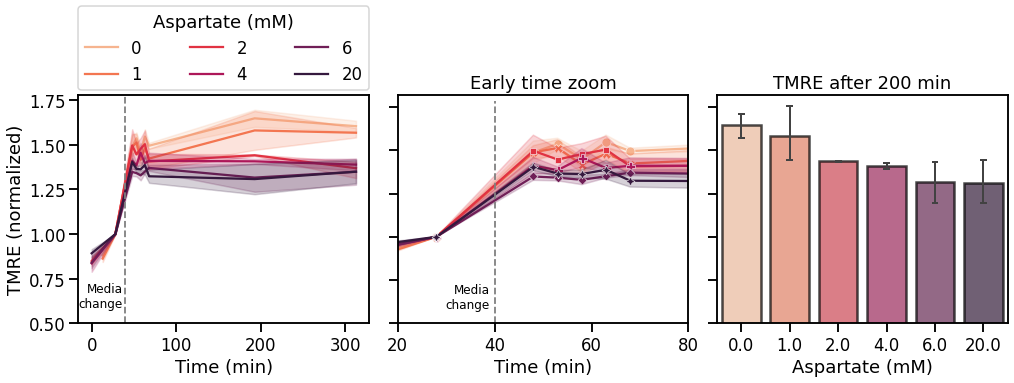

In [80]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 5.4))

g1 = sns.lineplot(ax=ax1, x='Time', y=var, hue='Conc_sns', data=TMRE_df, palette='rocket_r', style='Conc_sns', markers=False, dashes=False, zorder=1, errorbar=('ci', 90))
g1.set_ylabel('TMRE (normalized)');
g1.set_xlabel('Time (min)');
g1.set_ylim(0.5, g1.get_ylim()[1]+0.04)
# g1.vlines(x_intersection, *g1.get_ylim(), color='gray', linestyle='--')
g1.vlines(spike_time, *g1.get_ylim(), color='gray', linestyle='--', linewidth=1.8, zorder=2)
g1.text(spike_time-3, 0.59, 'Media\nchange', horizontalalignment='right', fontsize=12)

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = ['0', '1', '2', '4', '6', '20']
title = 'Aspartate (mM)'
g1.legend(handles, labels, title=title, bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=3)



g2 = sns.lineplot(ax=ax2, x='Time', y=var, hue='Conc_sns', data=TMRE_df, palette='rocket_r', style='Conc_sns', markers=True, dashes=False, zorder=1, errorbar=('ci', 90))
g2.set_ylabel('TMRE (normalized)');
g2.set_xlabel('Time (min)');
g2.set_ylim(0.5, g1.get_ylim()[1]+0.04)
g2.set_xlim(20, 80)
# g1.vlines(x_intersection, *g1.get_ylim(), color='gray', linestyle='--')
g2.vlines(spike_time, *g1.get_ylim(), color='gray', linestyle='--', linewidth=1.8, zorder=2)
g2.text(spike_time-1, 0.59, 'Media\nchange', horizontalalignment='right', fontsize=12)
g2.set_ylabel(None);
g2.set_yticklabels([])
g2.legend([],[], frameon=False)
g2.set_title('Early time zoom')




g3 = sns.barplot(ax=ax3, x='Conc', y=var, data=inter_df, palette='rocket_r', capsize=.1, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7)
g3.set_ylim(0.5, g1.get_ylim()[1]+0.04)
#g2.set_ylabel('TMRE (normalized)');
g3.set_ylabel(None);
g3.set_xlabel('Aspartate (mM)');
g3.set_title('TMRE after {} min'.format(str(x_intersection)))
g3.set_yticklabels([])


plt.tight_layout(pad=0.5)
fig.savefig('plots/HT1080-2xGOT-KO_Asp-titration.pdf', bbox_inches='tight')

# BAM15 titration

In [64]:
# Process TMRE data:
mask = np.array([v[6:11] == 'BAM15' for v in TMRE_stat['Plate'].values])
TMRE_df = TMRE_stat[mask]
TMRE_df['Replicate'] = [int(v[-1]) for v in TMRE_df['Well'].values]
pw2conc = {'p1A': 0, 'p1B': 0.1, 'p2A': 0.3, 'p2B': 1, 'p3A': 3, 'p3B': 10}
TMRE_df['Conc'] = [pw2conc[p.split('-')[-1]+w[0]] for p, w in zip(TMRE_df['Plate'].values, TMRE_df['Well'].values)]
TMRE_df = TMRE_df.drop(['Plate', 'Well'], axis=1)
TMRE_df['Time'] = time2min(TMRE_df['Time'].values)

<ipython-input-64-2fa5adb77943>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TMRE_df['Replicate'] = [int(v[-1]) for v in TMRE_df['Well'].values]
<ipython-input-64-2fa5adb77943>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TMRE_df['Conc'] = [pw2conc[p.split('-')[-1]+w[0]] for p, w in zip(TMRE_df['Plate'].values, TMRE_df['Well'].values)]


In [65]:
# Normalize stats to second read timepoint:
TMRE_df = norm2time(TMRE_df, 2)
# Align stats to second read timepoint:
TMRE_df, t_spike = align2time(TMRE_df, 2)

In [66]:
x_intersection = 200
spike_time = t_spike + 30
var = 'TMRE_sum_t2'

inter_df = vertical_intersection(TMRE_df, var, x_intersection)
c2abs = {'0.0': 'A', '0.1': 'B', '0.3': 'C', '1.0': 'D', '3.0': 'E', '10.0': 'G'}
TMRE_df['Conc_sns'] = [c2abs[str(c)] for c in TMRE_df['Conc'].values]

sns.set_context("talk")

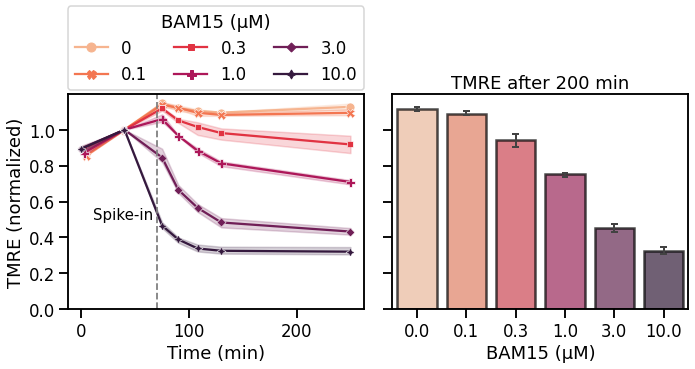

In [67]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5.5))

g1 = sns.lineplot(ax=ax1, x='Time', y=var, hue='Conc_sns', data=TMRE_df, palette='rocket_r', style='Conc_sns', markers=True, dashes=False, zorder=1)
g1.set_ylabel('TMRE (normalized)');
g1.set_xlabel('Time (min)');
g1.set_ylim(0, g1.get_ylim()[1])
# g1.vlines(x_intersection, *g1.get_ylim(), color='gray', linestyle='--')
g1.vlines(spike_time, *g1.get_ylim(), color='gray', linestyle='--', linewidth=1.8, zorder=2)
g1.text(spike_time-3, 0.5, 'Spike-in', horizontalalignment='right', fontsize=15)

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = ['0', '0.1', '0.3', '1.0', '3.0', '10.0']
title = 'BAM15 (μM)'
g1.legend(handles, labels, title=title, bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=3)


g2 = sns.barplot(ax=ax2, x='Conc', y=var, data=inter_df, palette='rocket_r', capsize=.1, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7)
g2.set_ylim(0, g1.get_ylim()[1])
#g2.set_ylabel('TMRE (normalized)');
g2.set_ylabel(None);
g2.set_xlabel('BAM15 (μM)');
g2.set_title('TMRE after {} min'.format(str(x_intersection)))
g2.set_yticklabels([])

plt.tight_layout()
fig.savefig('plots/HT1080-2xGOT-KO_BAM15-titration.pdf', bbox_inches='tight')